In [1]:
# Install detectron2
import torch
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-qiwzcqiy
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-qiwzcqiy


In [2]:
# clone and install Mask2Former
!git clone https://github.com/facebookresearch/Mask2Former.git
%cd Mask2Former
!pip install -U opencv-python
!pip install git+https://github.com/cocodataset/panopticapi.git
!pip install -r requirements.txt
%cd mask2former/modeling/pixel_decoder/ops
!python setup.py build install
%cd ../../../../

fatal: destination path 'Mask2Former' already exists and is not an empty directory.
/content/Mask2Former
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/panopticapi.git to /tmp/pip-req-build-ap4c121e
  Running command git clone -q https://github.com/cocodataset/panopticapi.git /tmp/pip-req-build-ap4c121e
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/content/Mask2Former/mask2former/modeling/pixel_decoder/ops
running build
running build_py
running build_ext
/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py:476: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
/usr/local/lib/pytho

In [3]:
%cd /content/Mask2Former
import detectron2
from detectron2.utils.logger import setup_logger

import numpy as np
import cv2
import torch
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog
from detectron2.projects.deeplab import add_deeplab_config
coco_metadata = MetadataCatalog.get("coco_2017_val_panoptic")

# import Mask2Former project
from mask2former import add_maskformer2_config

/content/Mask2Former


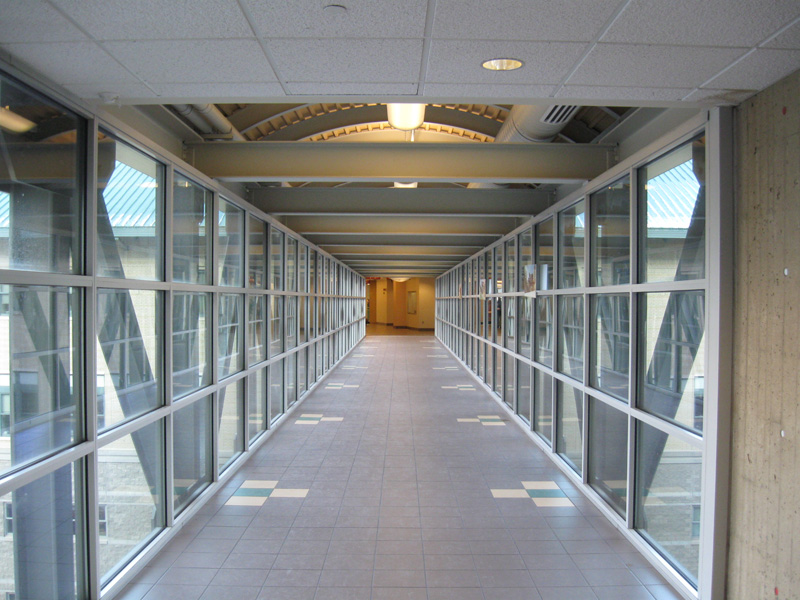

In [4]:
im = cv2.imread("/content/images/1.jpg")
cv2_imshow(im)

In [5]:
# Obtain segmentation results
cfg = get_cfg()
add_deeplab_config(cfg)
add_maskformer2_config(cfg)
cfg.merge_from_file("configs/coco/panoptic-segmentation/swin/maskformer2_swin_base_IN21k_384_bs16_50ep.yaml")
cfg.MODEL.WEIGHTS = 'https://dl.fbaipublicfiles.com/maskformer/mask2former/coco/panoptic/maskformer2_swin_base_IN21k_384_bs16_50ep/model_final_54b88a.pkl'
cfg.MODEL.MASK_FORMER.TEST.SEMANTIC_ON = True
cfg.MODEL.MASK_FORMER.TEST.INSTANCE_ON = True
cfg.MODEL.MASK_FORMER.TEST.PANOPTIC_ON = True
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Semantic Segmentation Results


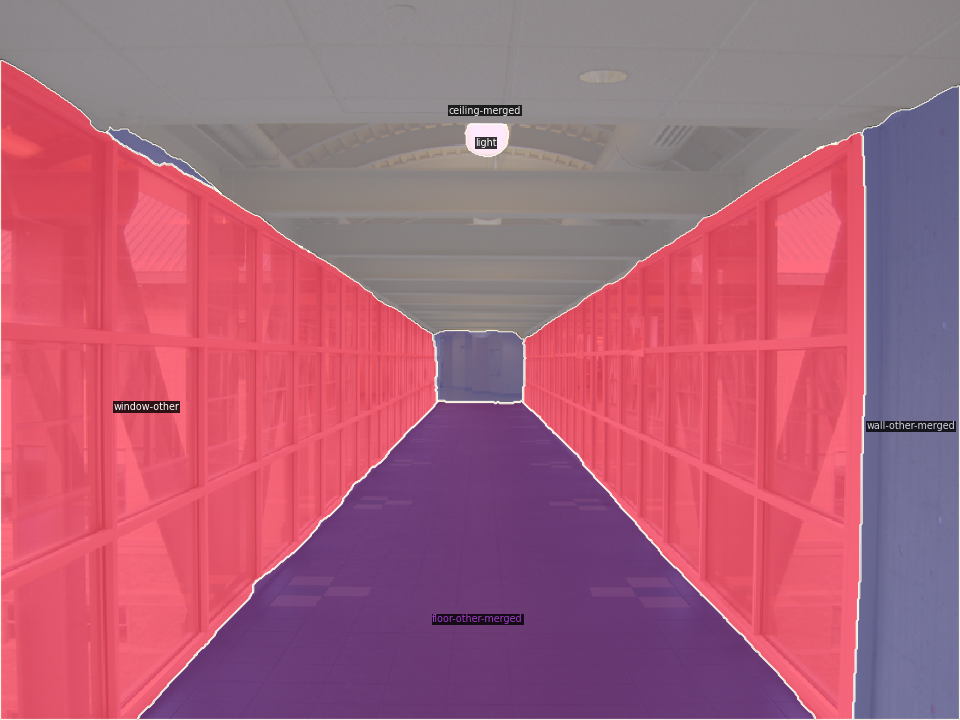

In [6]:
# Show prediction results
v = Visualizer(im[:, :, ::-1], coco_metadata, scale=1.2, instance_mode=ColorMode.IMAGE_BW)
semantic_result = v.draw_sem_seg(outputs["sem_seg"].argmax(0).to("cpu")).get_image()
print("Semantic Segmentation Results")
semantic_result = cv2.cvtColor(semantic_result, cv2.COLOR_BGR2RGB)
cv2_imshow(semantic_result)

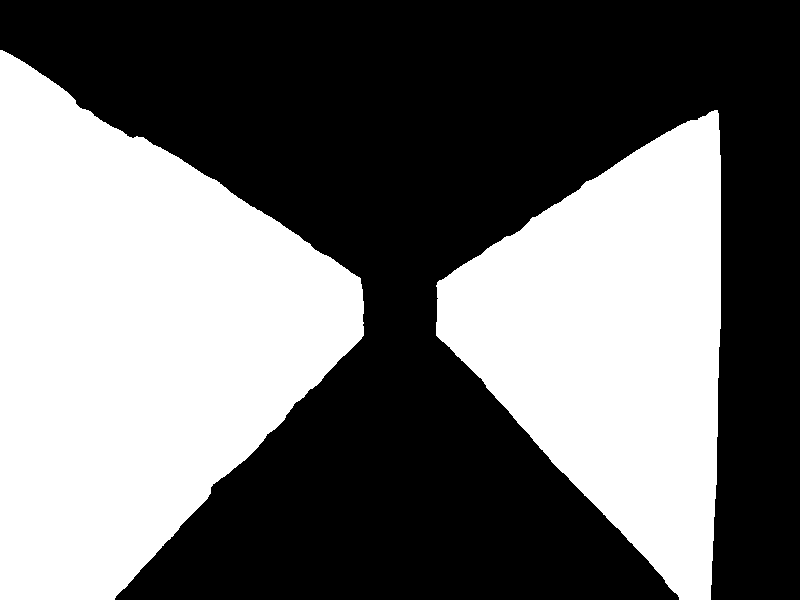

In [7]:
# Extract binary mask from segmentation mask
sem_seg = outputs["sem_seg"].argmax(0).to("cpu")
sem_seg = sem_seg.numpy()
labels, areas = np.unique(sem_seg, return_counts=True)
sorted_idxs = np.argsort(-areas).tolist()
labels = labels[sorted_idxs]
binary_mask = (sem_seg == 115).astype(np.uint8)
cv2_imshow(binary_mask * 255)